In [2]:
import os
import librosa
import librosa.display
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
np.random.seed(42)
genres = {'black': 0, 'death': 1}
features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}

file_name = "../Data/songs/small_test_set/black/01. Funeral Fog - Mayhem.mp3"

signal, sr = librosa.load(file_name)
print(signal)

n_fft = 1024
hop_length = 512

# Count silence
if 0 < len(signal):
    y_sound, _ = librosa.effects.trim(signal, frame_length=n_fft, hop_length=hop_length)
features['sample_silence'] = len(signal) - len(y_sound)

C:\Users\user\anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.1518726e-05 7.0048081e-05
 8.0470498e-05]


In [4]:
# Using librosa to calculate the features
y = signal
features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()

# MFCC treatment
mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
for idx, v_mfcc in enumerate(mfcc):
    features['mfcc_{}'.format(idx)] = v_mfcc.ravel()

# Get statistics from the vectors
def get_moments(descriptors):
    result = {}
    for k, v in descriptors.items():
        result['{}_max'.format(k)] = np.max(v)
        result['{}_min'.format(k)] = np.min(v)
        result['{}_mean'.format(k)] = np.mean(v)
        result['{}_std'.format(k)] = np.std(v)
        result['{}_kurtosis'.format(k)] = kurtosis(v)
        result['{}_skew'.format(k)] = skew(v)
    return result

dict_agg_features = get_moments(features)
dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]

print(dict_agg_features[i] for i in dict_agg_features)

<generator object <genexpr> at 0x000001EE602B6DD0>


In [5]:
for i in dict_agg_features:
    print(i, dict_agg_features[i])

centroid_max 4670.913561542345
centroid_min 0.0
centroid_mean 2939.8097717903897
centroid_std 436.85151520614824
centroid_kurtosis 12.29646429166281
centroid_skew -2.0143635544701133
roloff_max 8850.146484375
roloff_min 0.0
roloff_mean 5613.406294531668
roloff_std 924.1036094007283
roloff_kurtosis 10.785998209534347
roloff_skew -1.8885566855765579
flux_max 23.958563
flux_min 0.0
flux_mean 0.99935734
flux_std 0.555814
flux_kurtosis 232.52659678976343
flux_skew 7.101588249206543
rmse_max 0.3346017
rmse_min 0.0
rmse_mean 0.1826032
rmse_std 0.0375981
rmse_kurtosis 3.658602012563871
rmse_skew -0.8782880902290344
zcr_max 0.361328125
zcr_min 0.0
zcr_mean 0.1656920848029219
zcr_std 0.04385220477066581
zcr_kurtosis 1.8686180439608089
zcr_skew -0.2844608653678278
contrast_max 49.97214957828288
contrast_min 4.07197781986925
contrast_mean 18.065653416775962
contrast_std 6.958078403561781
contrast_kurtosis 0.9845964493286998
contrast_skew 1.4191570383586247
bandwidth_max 3479.2430211139376
bandwidt

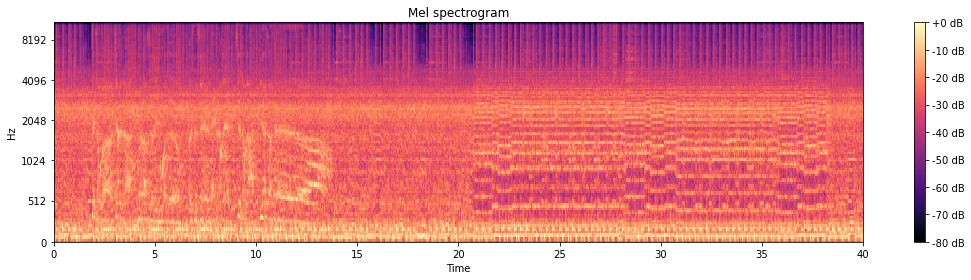

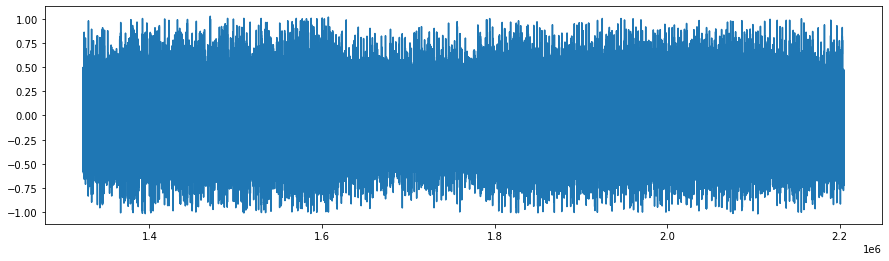

In [19]:
plt.figure(figsize=(15, 4))
file_name = "../Data/songs/full_test_set/death/Possessed - 01 - The Exorcist.mp3"
signal, sr = librosa.load(file_name)
S = librosa.feature.melspectrogram(y=signal[sr*60:sr*100], sr=sr)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

plt.figure(figsize=(15, 4))
plt.plot(np.linspace(sr*60, sr*100, num=sr*40), signal[sr*60:sr*100])

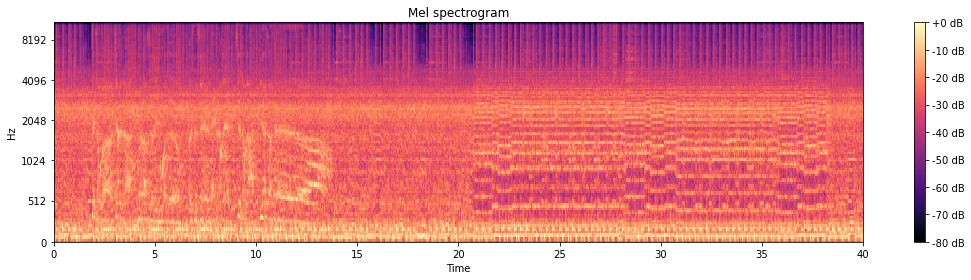

In [23]:
plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

C:\Users\user\anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
C:\Users\user\anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


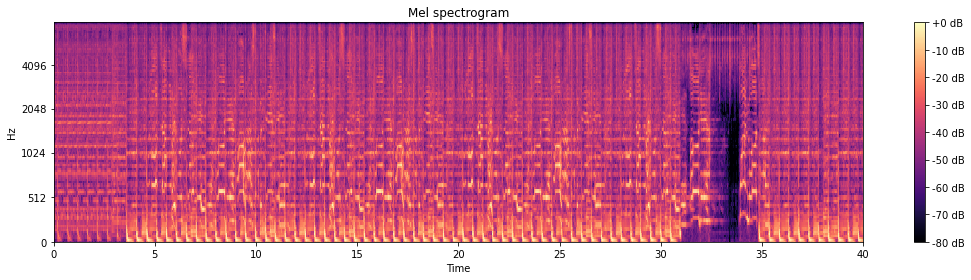

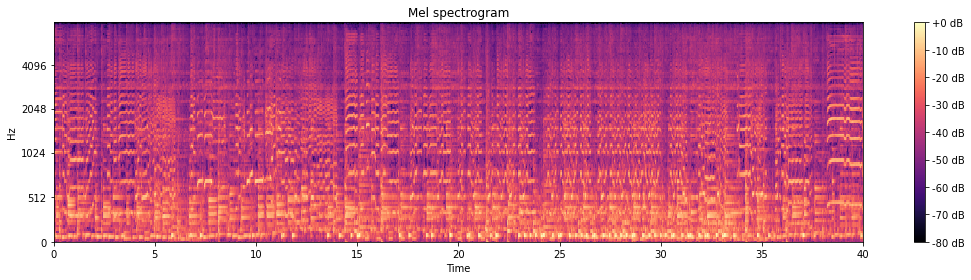

In [11]:
# visualise non-metal songs
signal1, sr1 = librosa.load("../Data/songs/non_metal_set/daft_punk.mp3")
signal2, sr2 = librosa.load("../Data/songs/non_metal_set/coltrane.mp3")

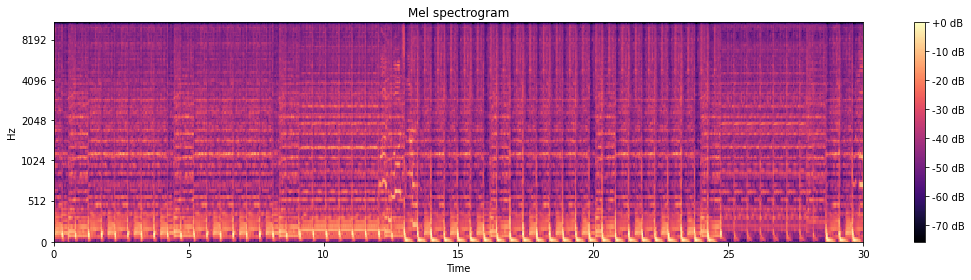

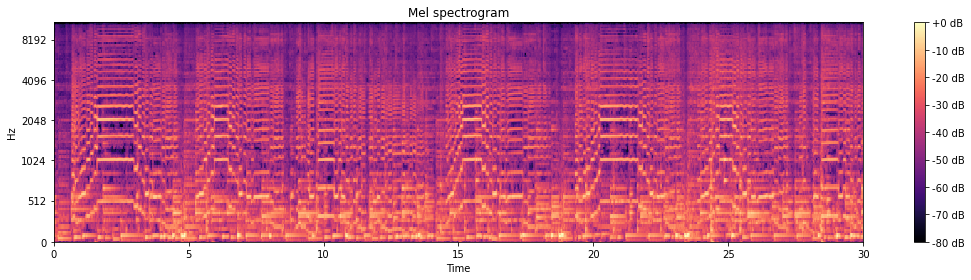

In [18]:
S1 = librosa.feature.melspectrogram(y=signal1[sr*35:sr*65], sr=sr1)
S2 = librosa.feature.melspectrogram(y=signal2[sr*5:sr*35], sr=sr2)

plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.power_to_db(S1, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

plt.figure(figsize=(15, 4))
librosa.display.specshow(librosa.power_to_db(S2, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()